<a href="https://colab.research.google.com/github/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/blob/main/Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install arviz

In [5]:
!pip install pymc3==3.8

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [61]:
def plot(x, y, mu_pred, y_pred, title, ax, alpha=0.89):
  idx = np.argsort(x.values)
  x_ord = x.values[idx]
  y_pred_hpd_ord = az.hdi(y_pred, alpha)[idx]
  mu_hpd_ord = az.hdi(mu_pred, alpha)[idx]
  mu_mean_ord = np.mean(mu_pred, axis=0)[idx]

  ax.scatter(x, y, c='C0', alpha=0.3)
  ax.plot(x_ord, mu_mean_ord, color='C2')
  ax.fill_between(x_ord, mu_hpd_ord[:,0], mu_hpd_ord[:,1], color='C2', alpha=0.25)
  ax.fill_between(x_ord, y_pred_hpd_ord[:,0], y_pred_hpd_ord[:,1], color='C2', alpha=0.25)
  ax.set_xlabel('weight', fontsize=14)
  ax.set_ylabel('height', fontsize=14)
  ax.set_title(title, fontsize=20)

## Linear Regression

In [8]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d2 = d[d.age > 18]
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))
d2.head()

,height,weight,age,male,weight_c
0,151.765,47.825606,63.0,1,2.780064
1,139.700,36.485807,63.0,0,-8.559736
2,136.525,31.864838,65.0,0,-13.180705
3,156.845,53.041915,41.0,1,7.996372
4,145.415,41.276872,51.0,0,-3.768671


In [9]:
# 4.42
with pm.Model() as m_4_4_2:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight_c)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1151.52it/s]


In [10]:
with m_4_4_2:
    summary = pm.summary(
        trace_4_4_2,
        var_names=["alpha", "beta", "sigma"],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.650,0.274,154.155,155.163,0.005,0.004,2897.0,2897.0,2927.0,1487.0,1.0
beta,0.904,0.044,0.825,0.987,0.001,0.001,2889.0,2887.0,2883.0,1351.0,1.0
sigma,5.144,0.203,4.774,5.521,0.004,0.003,2428.0,2402.0,2439.0,1398.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


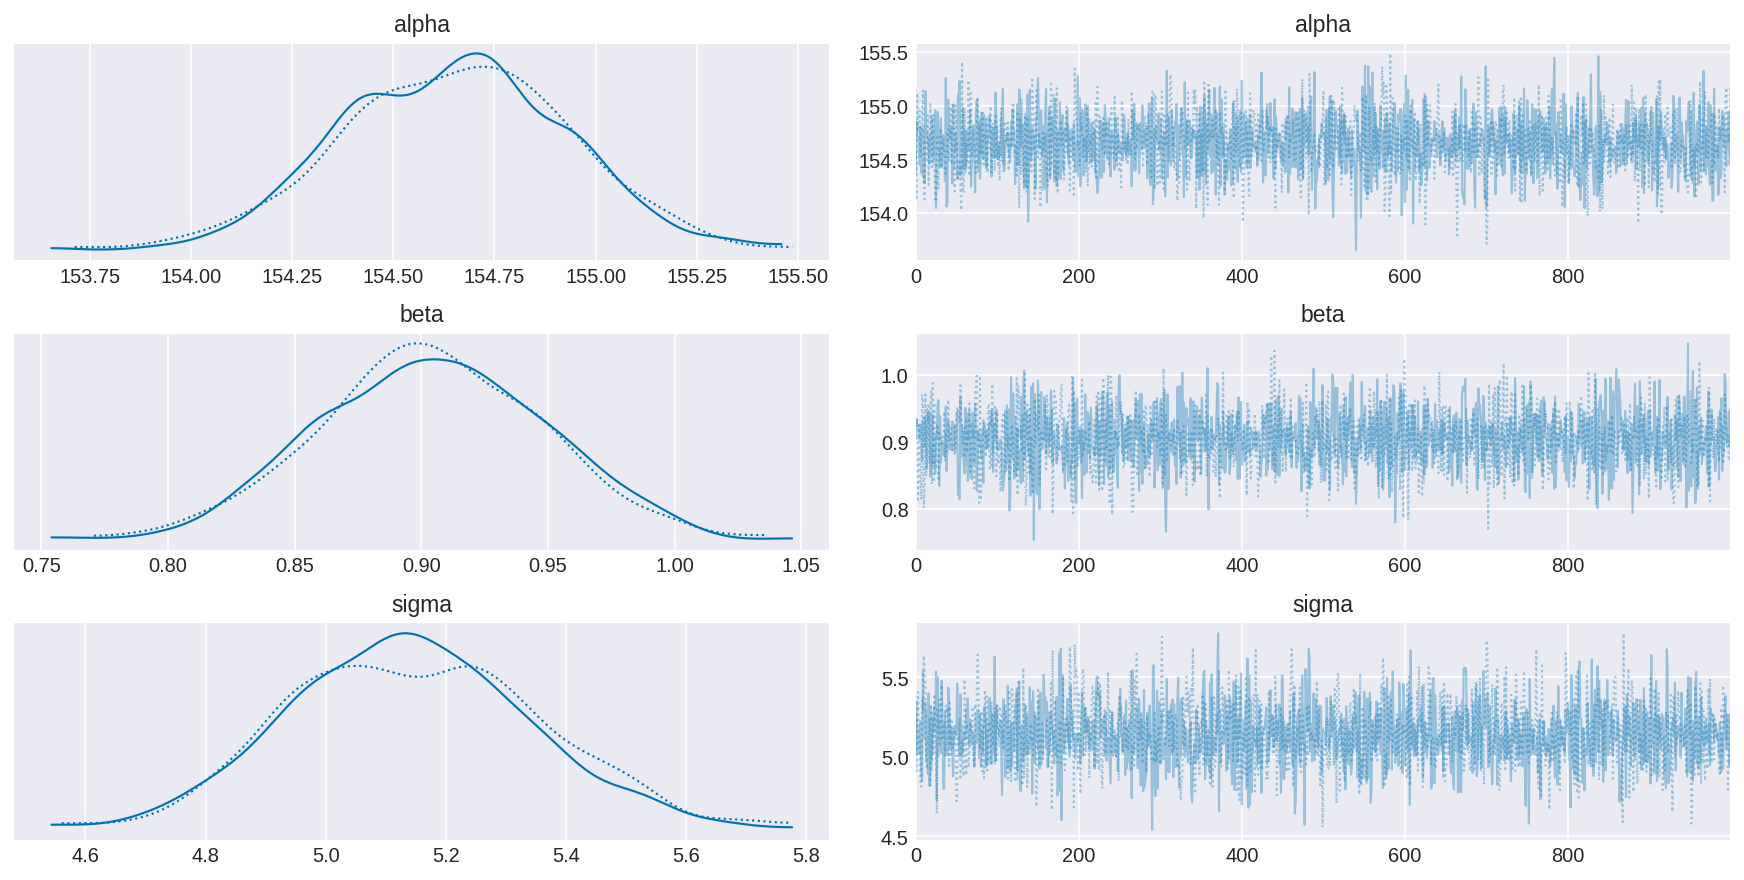

In [11]:
_ = pm.traceplot(trace_4_4_2, var_names=["alpha", "beta", "sigma"])

In [12]:
pm.trace_to_dataframe(trace_4_4_2)[:5]

,alpha,beta,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16,mu__17,mu__18,mu__19,mu__20,mu__21,mu__22,mu__23,mu__24,mu__25,mu__26,mu__27,mu__28,mu__29,mu__30,mu__31,mu__32,mu__33,mu__34,mu__35,mu__36,...,mu__306,mu__307,mu__308,mu__309,mu__310,mu__311,mu__312,mu__313,mu__314,mu__315,mu__316,mu__317,mu__318,mu__319,mu__320,mu__321,mu__322,mu__323,mu__324,mu__325,mu__326,mu__327,mu__328,mu__329,mu__330,mu__331,mu__332,mu__333,mu__334,mu__335,mu__336,mu__337,mu__338,mu__339,mu__340,mu__341,mu__342,mu__343,mu__344,mu__345
0,154.366223,0.922688,5.352119,156.931354,146.468260,142.204549,161.744377,150.888917,170.925741,148.090039,163.993942,144.977269,163.078421,158.840868,150.836602,146.049736,156.815458,144.035591,157.611455,151.856753,148.194670,158.003821,152.222961,145.552739,147.776147,145.526582,149.999554,163.653891,147.409938,148.325459,155.806571,148.639352,145.631212,156.538988,156.983669,158.396187,158.370029,164.987936,148.900929,158.840868,...,156.434357,155.361890,156.538988,150.496551,159.259392,154.446369,151.778280,151.228968,154.524842,160.096439,158.265398,160.044124,153.269271,145.578897,152.373104,155.963517,151.438229,148.049925,152.755632,162.293689,152.458381,149.502557,152.798432,161.404326,148.273144,152.301435,145.918948,153.609321,147.933093,153.504690,153.426217,156.983669,149.162507,150.679655,150.470393,156.198937,144.401799,160.933487,162.686055,161.273537
1,154.853264,0.934388,5.349799,157.450921,146.855151,142.537375,162.324975,151.331864,171.622763,148.497495,164.603065,145.345254,163.675935,159.384649,151.278885,146.431320,157.333556,144.391635,158.139646,152.311973,148.603453,158.536987,152.682824,145.928021,148.179622,145.901532,150.431223,164.258703,147.808770,148.735900,156.311876,149.053773,146.007490,157.053579,157.503900,158.934329,158.907839,165.609663,149.318668,159.384649,...,156.947622,155.861555,157.053579,150.934523,159.808480,154.934426,152.232504,151.676226,155.013894,160.656141,158.801881,160.603162,153.742401,145.954511,152.834871,156.470812,151.888142,148.456873,153.222250,162.881253,152.921229,149.927924,153.265592,161.980612,148.682921,152.762293,146.298873,154.086764,148.338559,153.980806,153.901338,157.503900,149.583562,151.119948,150.908033,156.709217,144.762487,161.503803,163.278594,161.848165
2,154.710218,0.923495,5.021714,157.277593,146.805341,142.537899,162.094829,151.229868,171.284230,148.428541,164.346363,145.313046,163.430041,159.188779,151.177507,146.386451,157.161596,144.370543,157.958290,152.198551,148.533263,158.350999,152.565080,145.889019,148.114373,145.862839,150.339726,164.006015,147.747844,148.664166,156.151826,148.978334,145.967561,156.884884,157.329955,158.743709,158.717528,165.341227,149.240140,159.188779,...,156.780161,155.706756,156.884884,150.837158,159.607669,154.790434,152.120009,151.570216,154.868975,160.445450,158.612805,160.393088,153.612305,145.915200,152.715354,156.308910,151.779661,148.388391,153.098217,162.644622,152.800706,149.842295,153.141054,161.754481,148.611805,152.643622,146.255548,153.952653,148.271457,153.847931,153.769389,157.329955,149.501946,151.020423,150.810978,156.544536,144.737072,161.283230,163.037332,161.623578
3,154.710218,0.923495,5.021714,157.277593,146.805341,142.537899,162.094829,151.229868,171.284230,148.428541,164.346363,145.313046,163.430041,159.188779,151.177507,146.386451,157.161596,144.370543,157.958290,152.198551,148.533263,158.350999,152.565080,145.889019,148.114373,145.862839,150.339726,164.006015,147.747844,148.664166,156.151826,148.978334,145.967561,156.884884,157.329955,158.743709,158.717528,165.341227,149.240140,159.188779,...,156.780161,155.706756,156.884884,150.837158,159.607669,154.790434,152.120009,151.570216,154.868975,160.445450,158.612805,160.393088,153.612305,145.915200,152.715354,156.308910,151.779661,148.388391,153.098217,162.644622,152.800706,149.842295,153.141054,161.754481,148.611805,152.643622,146.255548,153.952653,148.271457,15

Text(0, 0.5, 'height')

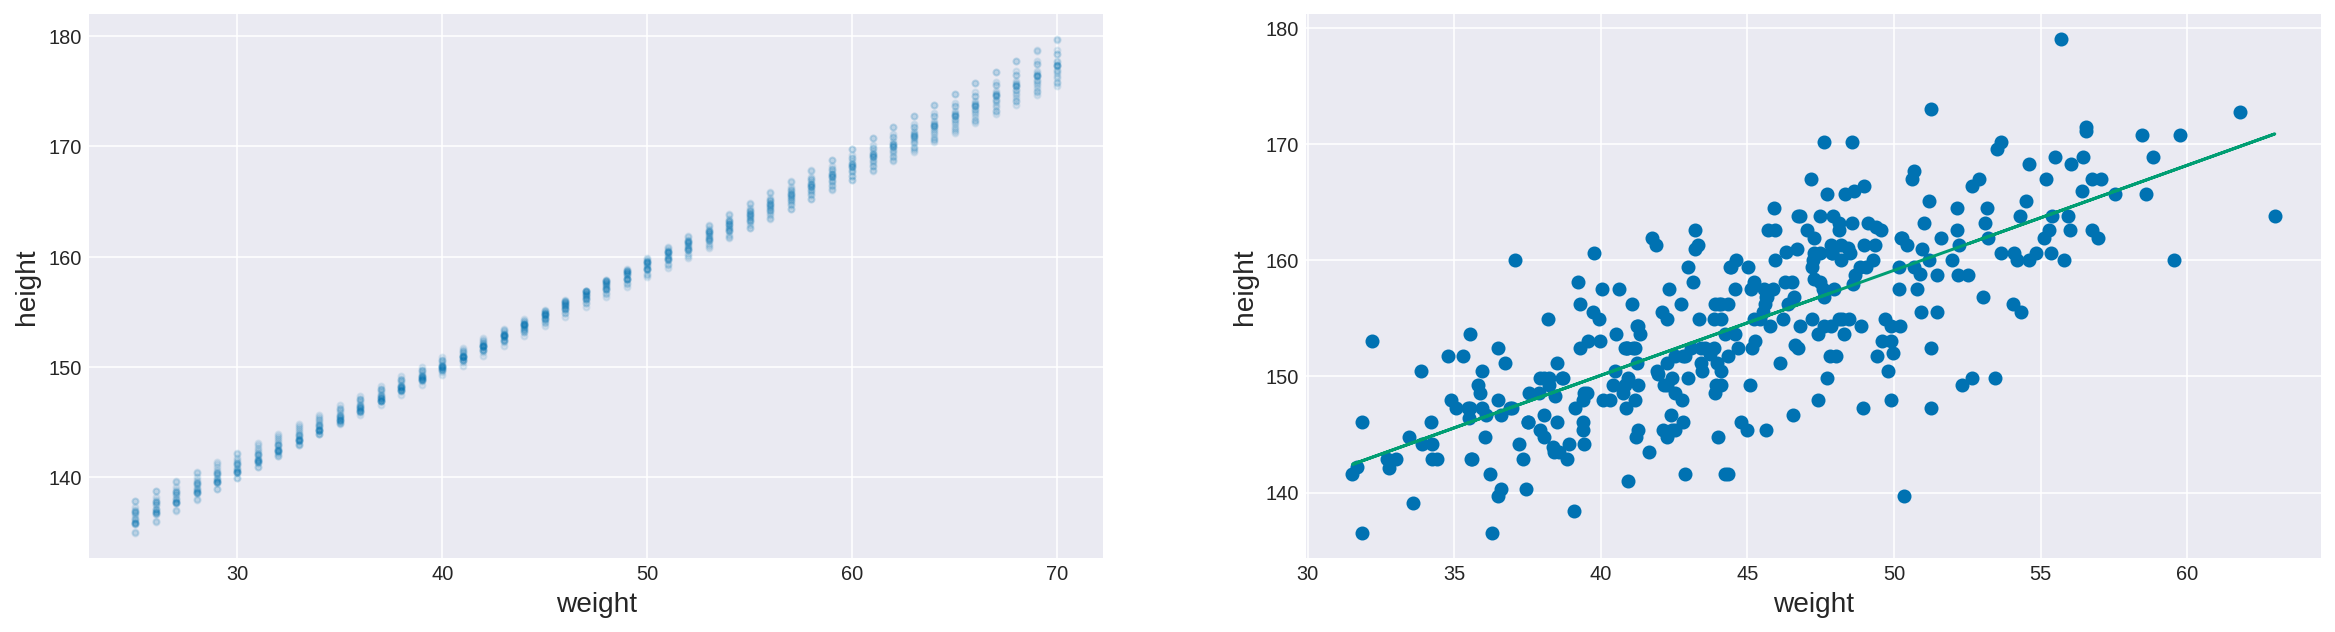

In [13]:
# 4.58
# We are doing manually, what in thebook is done using the link function. 
# In the book on code 4.58 the following operations are performed manually.
weigth_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = trace_4_4_2[::100]
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)*trace_4_4_2.nchains))

for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * (w - d2.weight.mean())

# plot the sample mu
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(weigth_seq, mu_pred, 'C0.', alpha=0.1)
ax[0].set_xlabel('weight', fontsize=14)
ax[0].set_ylabel('height', fontsize=14)

# plot raw data and mean 
ax[1].plot(d2.weight, d2.height, 'o')
ax[1].plot(d2.weight, trace_4_4_2['alpha'].mean() + trace_4_4_2['beta'].mean() * d2.weight_c)
ax[1].set_xlabel('weight', fontsize=14)
ax[1].set_ylabel('height', fontsize=14)

In [14]:
# Now we are going to use sample_ppc() from PyCM3. 
# This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. 
# Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)
predictive_4_4_2 = pm.sample_ppc(trace_4_4_2, 200, m_4_4_2)
mu_pred_4_4_2 = trace_4_4_2['mu']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:01<00:00, 193.25it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


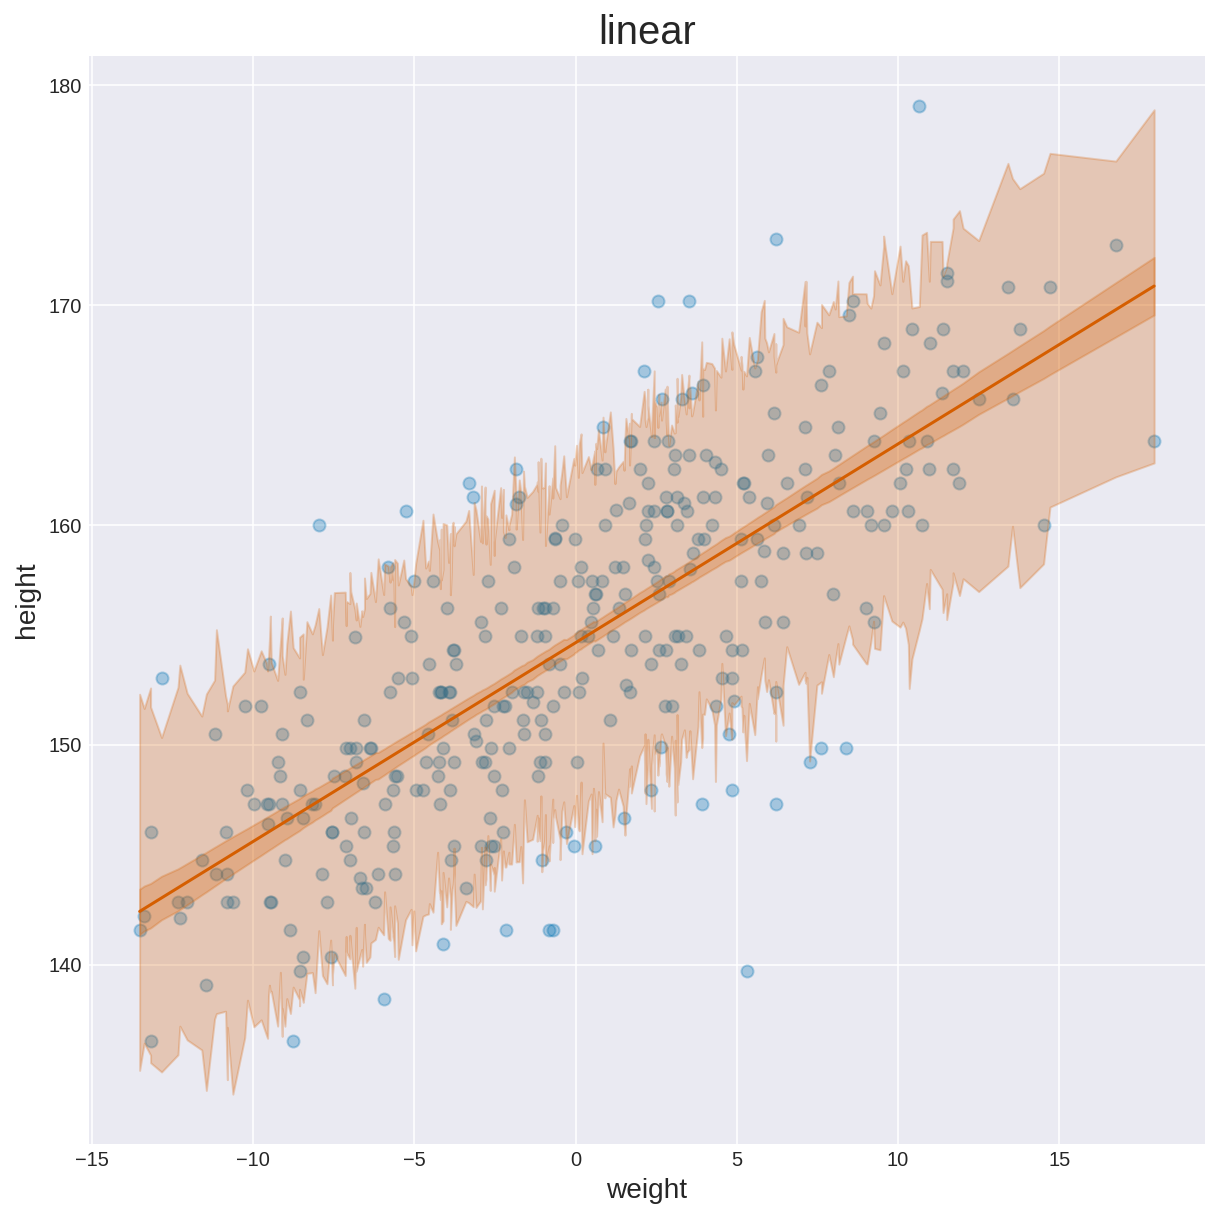

In [15]:
# The solid line is the average line for mean height
# The narrow shadow is the distribution of 89% interval of mu
# The wider shaded region is the 89% interval of the actual height at each weight
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d2.weight_c, d2.height, mu_pred_4_4_2, predictive_4_4_2['height'], 'linear', ax)

## Curve From Lines
- Polynominal Regression $\mu_i = \alpha + \beta_1x_i + \beta_2x_i^2$
- B-Splines

In [16]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d = d.assign(weight_s=pd.Series((d.weight - d.weight.mean())/d.weight.std()))
d.head()

,height,weight,age,male,weight_s
0,151.765,47.825606,63.0,1,0.829869
1,139.700,36.485807,63.0,0,0.059459
2,136.525,31.864838,65.0,0,-0.254483
3,156.845,53.041915,41.0,1,1.184257
4,145.415,41.276872,51.0,0,0.384957


In [17]:
with pm.Model() as model_linear:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_linear = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1076.22it/s]


In [21]:
with pm.Model() as model_quadratic:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s + beta2 * d.weight_s**2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_quadratic = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta2, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 723.31it/s]


In [19]:
with pm.Model() as model_cubic:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    beta3 = pm.Normal('beta3', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s + beta2 * d.weight_s**2 + beta3 * d.weight_s**3)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_cubic = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:05<00:00, 367.98it/s]


In [67]:
# calculate the mu hpd
mu_pred_linear = trace_linear['mu']
mu_pred_quadratic = trace_quadratic['mu']
mu_pred_cubic = trace_cubic['mu']

# generate sample predictive for height and caculate hpd
predictive_linear = pm.sample_posterior_predictive(trace_linear, 200, model_linear)
predictive_quadratic = pm.sample_posterior_predictive(trace_quadratic, 200, model_quadratic)
predictive_cubic = pm.sample_posterior_predictive(trace_cubic, 200, model_cubic)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 704.30it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


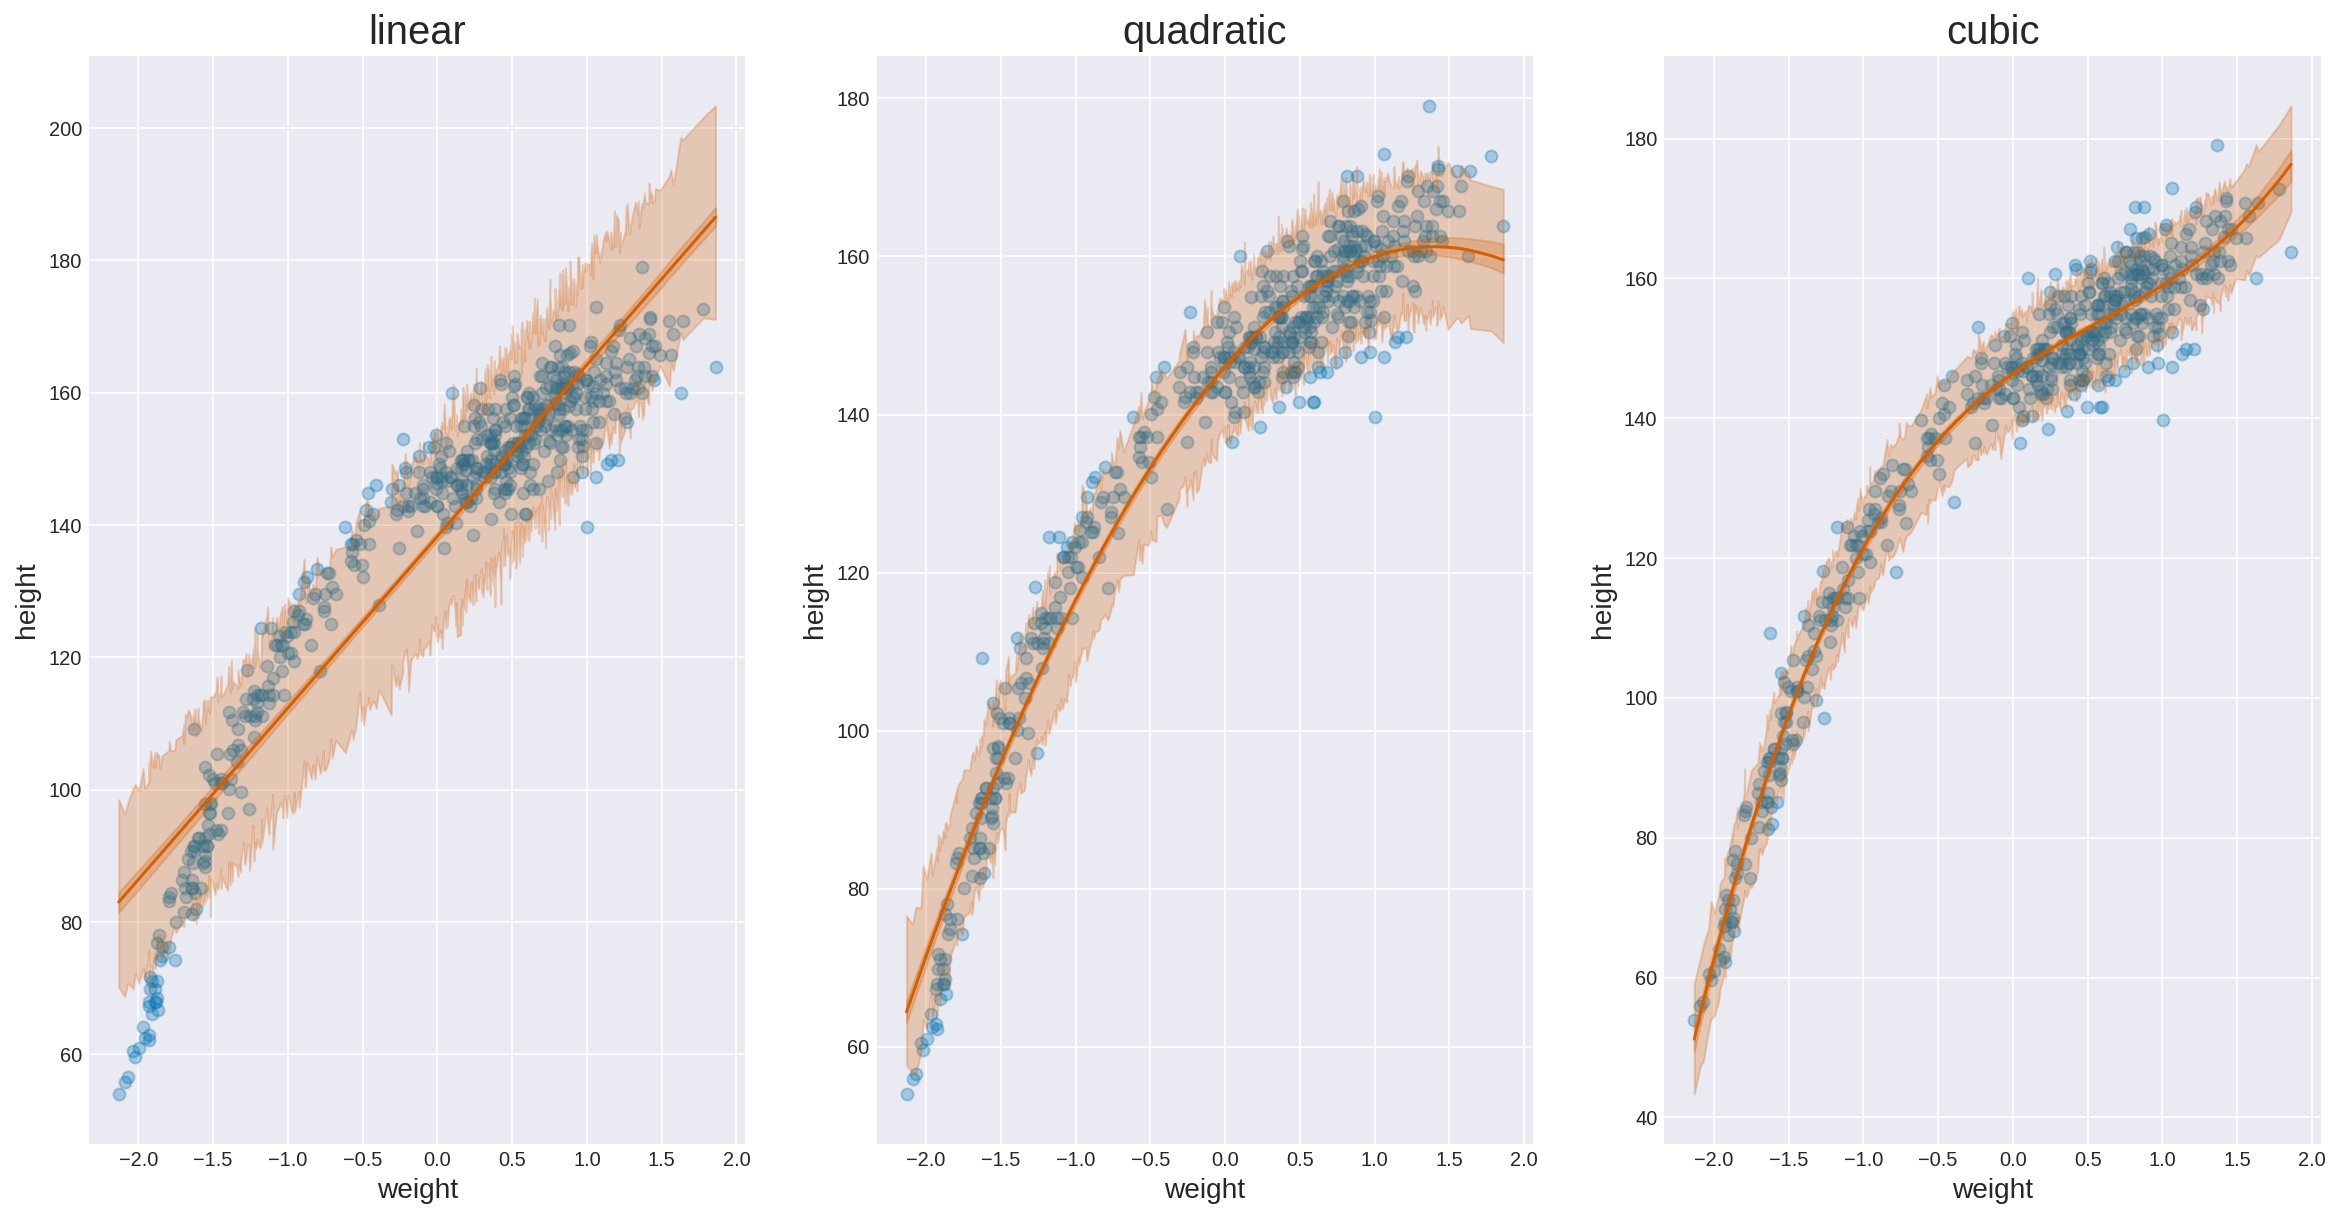

In [23]:
_, ax = plt.subplots(1, 3, figsize=(20, 10))
plot(d.weight_s, d.height, mu_pred_linear, predictive_linear['height'], 'linear', ax[0])
plot(d.weight_s, d.height, mu_pred_quadratic, predictive_quadratic['height'], 'quadratic', ax[1])
plot(d.weight_s, d.height, mu_pred_cubic, predictive_cubic['height'], 'cubic', ax[2])

In [24]:
# A simplified version of model definition
weight_m = np.vstack((d.weight_s, d.weight_s**2, d.weight_s**3))
with pm.Model() as model_cubic_s:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_cubic_s = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 479.94it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


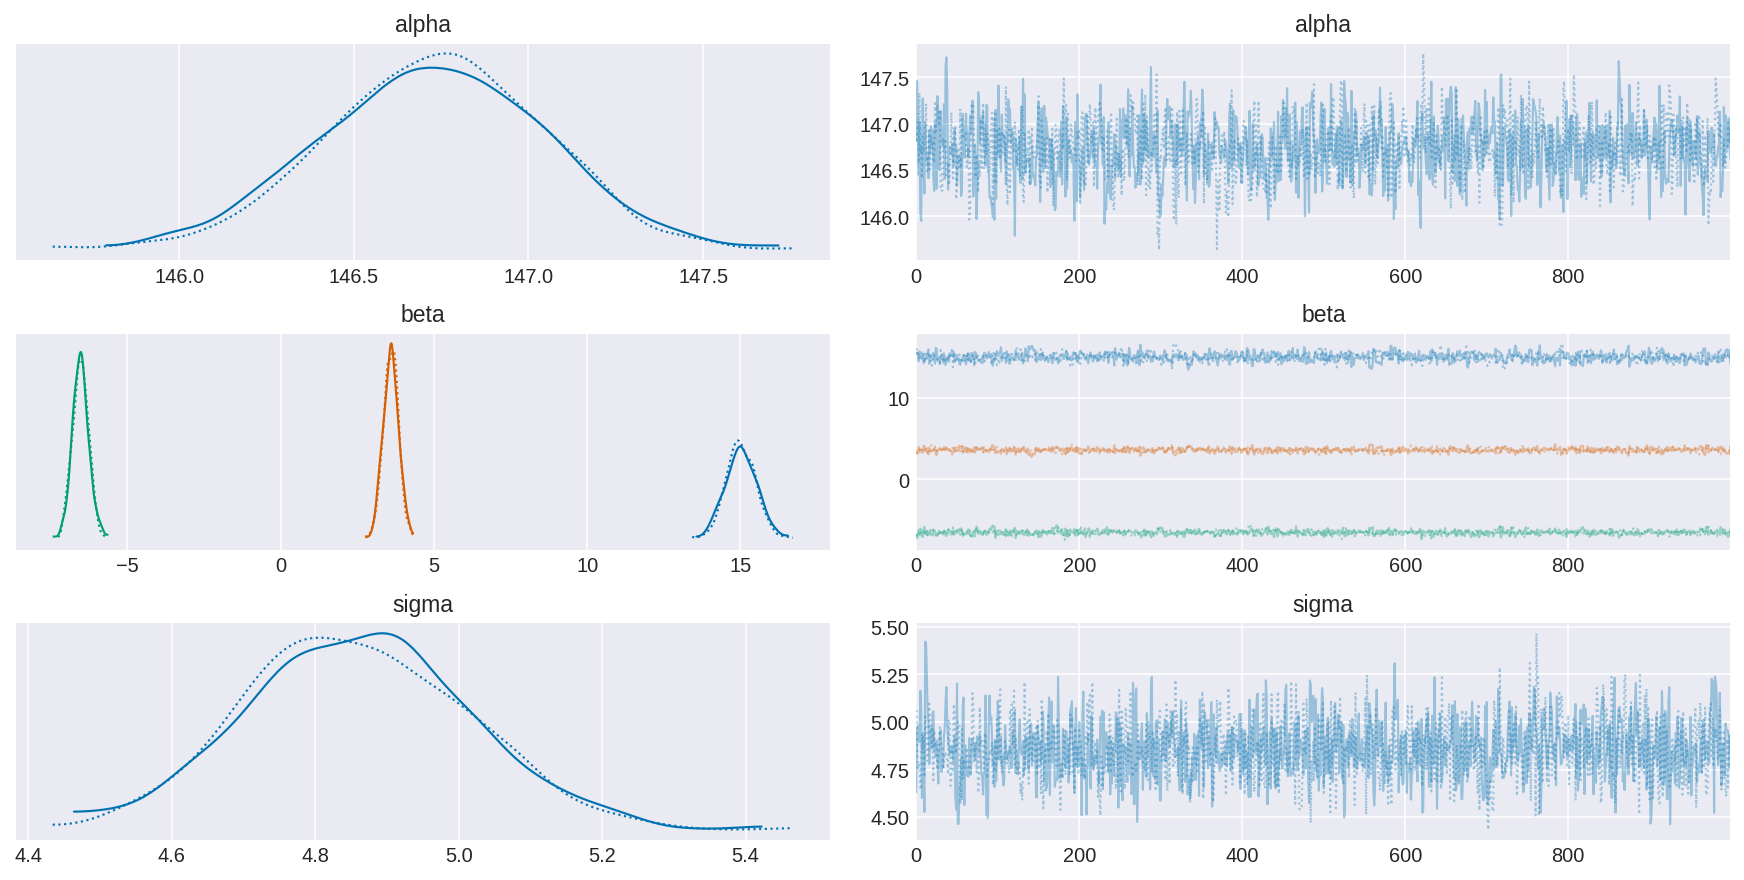

In [71]:
pm.traceplot(trace_cubic_s, ['alpha', 'beta', 'sigma']);

# Practice
- 4E1: $y_i$
- 4E2: 2
- 4E3: 
- 4E4: $\mu_i = \alpha + \beta x_i$
- 4E5: 3


In [38]:
# 4H1
with pm.Model() as model_h_4_1:
    alpha = pm.Normal('alpha', mu=100, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta*d2.weight)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_h_4_1 = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:32<00:00, 343.12it/s]


In [39]:
weight_inputs = [46.95, 43.72, 64.78, 32.59, 54.63]
height_mean = []
height_hpd = []
for i, w in enumerate(weight_inputs):
  y_pred = trace_h_4_1['alpha'] + trace_h_4_1['beta'] * w
  height_mean.append(np.mean(y_pred))
  height_hpd.append(az.hdi(y_pred, .89))

print(height_mean)
print(height_hpd)

[156.37087533959107, 153.4398802425833, 172.55033124660272, 143.3401974470118, 163.33992869718213]
[array([155.91140066, 156.85036515]), array([152.97660089, 153.88967238]), array([171.09200715, 173.98612326]), array([142.37405726, 144.31086928]), array([162.5830437 , 164.20435222])]


In [68]:
# 4H2
d3 = d[d.age < 18]
print(len(d3))

with pm.Model() as model_h_4_2:
    alpha = pm.Normal('alpha', mu=100, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta*d3.weight)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d3.height)
    trace_h_4_2 = pm.sample(10000, tune=1000)

    
with model_h_4_2:
  summary = pm.summary(trace_h_4_2, var_names=['alpha', 'beta', 'sigma'])
  parameters = pm.find_MAP()

beta_map = parameters['beta']
print(f'MAP of beta is {beta_map}')
summary

192


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:14<00:00, 762.07it/s]
logp = -694.75, ||grad|| = 10.271: 100%|██████████| 27/27 [00:00<00:00, 1425.50it/s]  

MAP of beta is 2.719600076548023


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,58.268,1.458,55.545,60.964,0.017,0.012,7159.0,7159.0,7177.0,7718.0,1.0
beta,2.719,0.071,2.582,2.850,0.001,0.001,7348.0,7319.0,7386.0,8181.0,1.0
sigma,8.539,0.450,7.702,9.381,0.004,0.003,10642.0,10590.0,10696.0,10287.0,1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 713.12it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


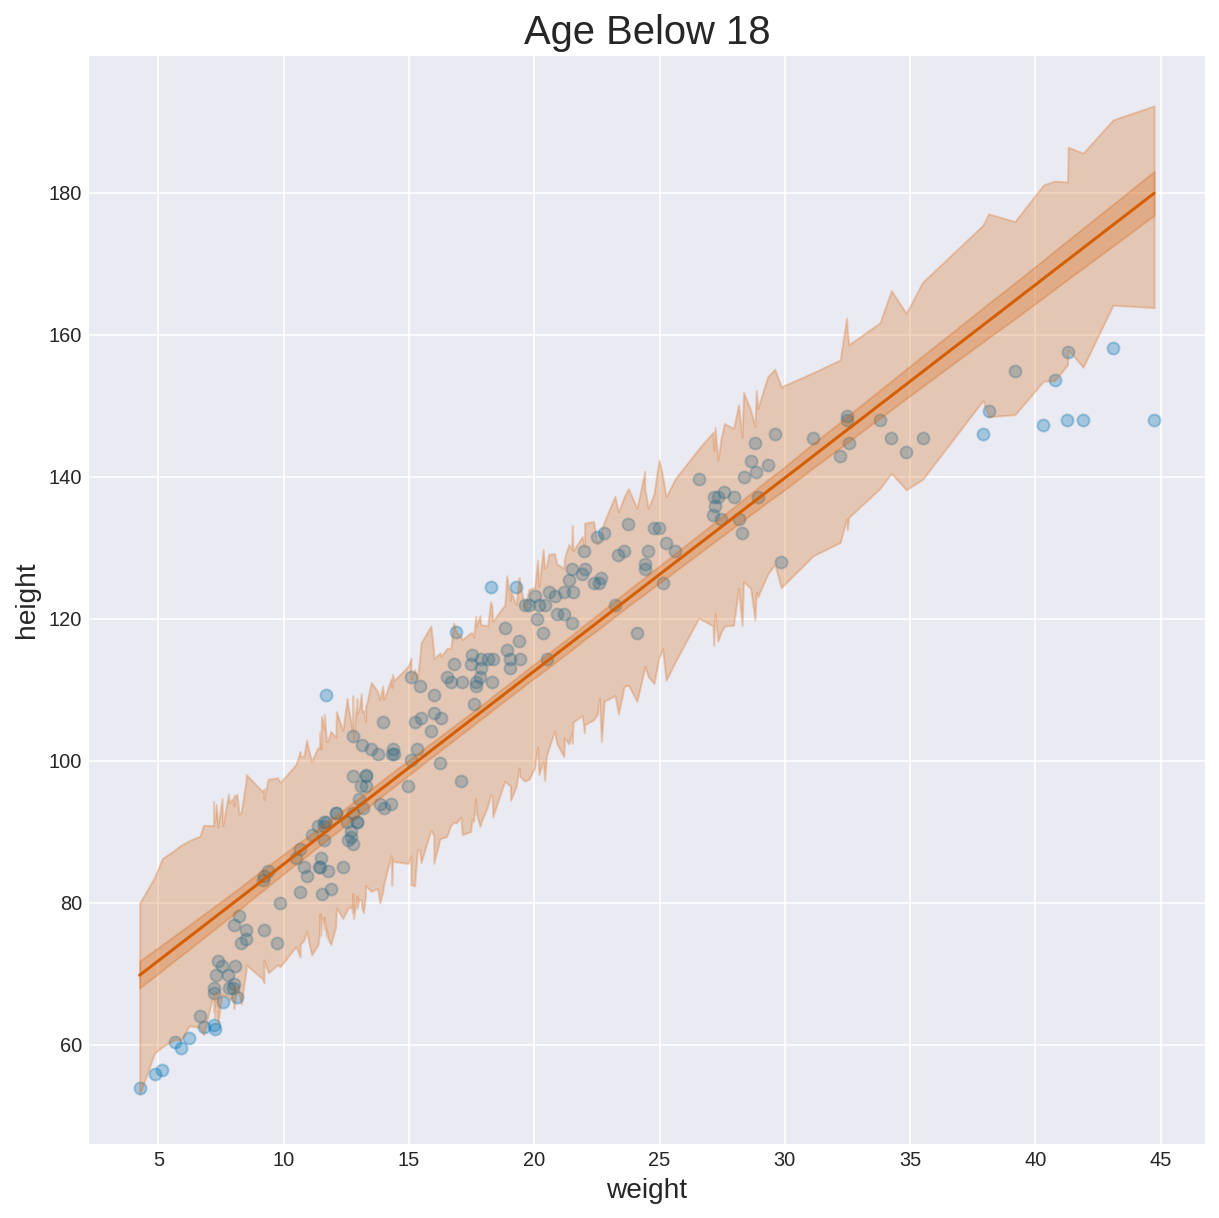

In [57]:
predictive_h_4_2 = pm.sample_posterior_predictive(trace_h_4_2, 200, model_h_4_2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d3.weight, d3.height, trace_h_4_2['mu'], predictive_h_4_2['height'], 'Age Below 18', ax)

In [60]:
# 4H3
with pm.Model() as model_h_4_3:
    alpha = pm.Normal('alpha', mu=138, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta*np.log(d.weight))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_h_4_3 = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:33<00:00, 325.60it/s]
The acceptance probability does not match the target. It is 0.8947347492961213, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815047942682722, but should be close to 0.8. Try to increase the number of tuning steps.


In [69]:
with model_h_4_3:
  summary = pm.summary(trace_h_4_3, var_names=['alpha', 'beta', 'sigma'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-23.780,1.358,-26.212,-21.103,0.017,0.012,6536.0,6536.0,6537.0,6323.0,1.0
beta,47.074,0.389,46.323,47.781,0.005,0.003,6525.0,6525.0,6528.0,6283.0,1.0
sigma,5.157,0.156,4.870,5.453,0.002,0.001,9076.0,9046.0,9099.0,8481.0,1.0


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 740.67it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


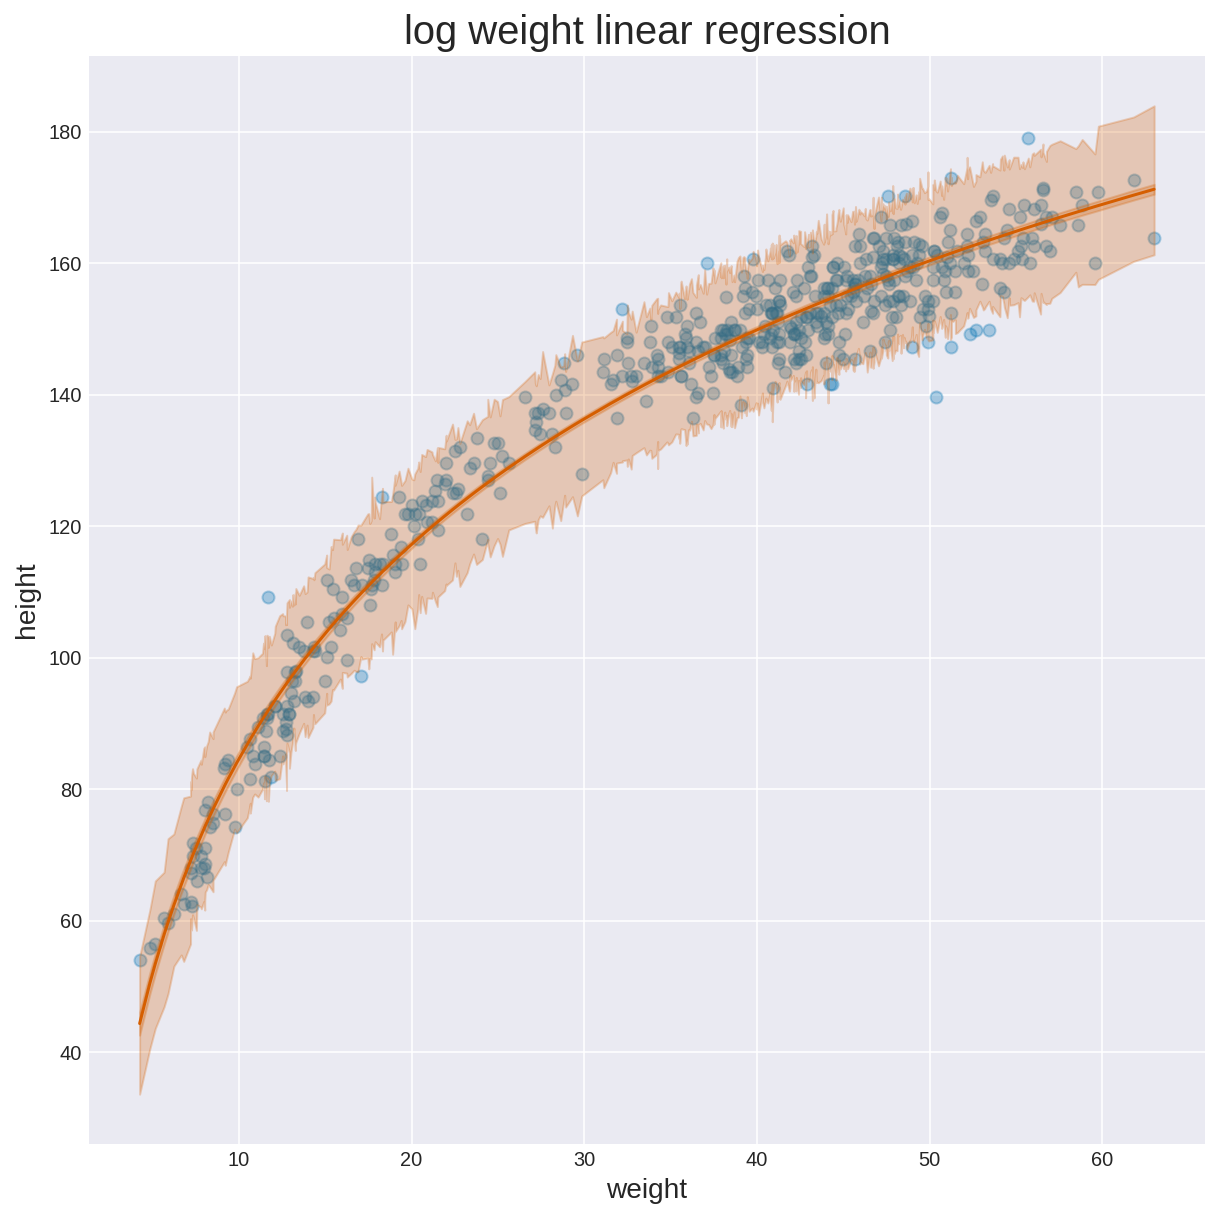

In [70]:
predictive_h_4_3 = pm.sample_posterior_predictive(trace_h_4_3, 200, model_h_4_3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d.weight, d.height, trace_h_4_3['mu'], predictive_h_4_3['height'], 'log weight linear regression', ax, 0.97)